# Machine Learning for Level Truncation in String Field Theory

In the framework of bosonic open string field theory (OSFT) we consider the locations of the vacua of the tachyon potential at several mass level truncations. We then extrapolate the predictions for the truncation at level-$\infty$ using machine learning (ML) techniques such as:

- [linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) (LR) as a baseline computation of the predictive abilities of a regression task,
- [elastic net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) (EN) to introduce regularisation (both $l_1$ and $l_2$ types) into the linear model (we can then refine the model using [lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) if needed),
- [SVR (linear kernel)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html) (LSVR) to introduce _support vectors_,
- [SVR (Gaussian kernel)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) (GSVR) to use the _kernel trick_ to improve the predictions,
- [random forests](https://xgboost.readthedocs.io/en/latest/tutorials/rf.html) (RF) of decision trees to introduce a _bagging_ ensemble learning,
- [boosted decision trees](https://xgboost.readthedocs.io/en/latest/index.html) (BDT) to introduce _boosting_ as ensemble learning technique,
- [artificial neural networks](https://www.tensorflow.org/) (ANN) to compute more complex regression functions in the attempt to improve the predictions.

In general we use [_Scikit-learn_](https://scikit-learn.org/stable/index.html), [_XGBoost_](https://xgboost.ai/) and [_Tensorflow_](https://www.tensorflow.org/) (in particular its high-level API, [_Keras_](https://keras.io/)) as reference libraries. We implement hyperparameters optimisation using [_Scikit-optimize_](https://scikit-optimize.github.io/stable/index.html) which introduces _Bayes_ optimisation.

# Preparation and Setup

Before adventuring further we first setup the environment and include module used throughout the notebook. We also take a look at the specifics of the machine we are working with.

In [1]:
print('Machine specifications:\n')
!echo "CPU: $(lscpu| awk '/^Model name/ {$1=""; $2=""; print}'| sed 's/^[[:space:]]*//g')"
!echo "GPU: $(lspci| awk '/3D controller/ {$1=""; $2=""; $3=""; print}'| sed 's/^[[:space:]]*//g')"
!echo "RAM: $(free --giga| awk '/^Mem/ {print $2}')GB (avail. now: $(free --giga| awk '/^Mem/ {print $7}')GB)"

Machine specifications:

CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
GPU: NVIDIA Corporation GM108M [GeForce 940MX] (rev a2)
RAM: 16GB (avail. now: 9GB)


We then immediately decide how many cores/threads to allocate for the analysis such that it will be easy to adjust them in the future if more concurrent analysis are under way:

In [2]:
import os

THREADS = 8 #-------------------------------------------------------------------- no. of desired threads
MAX_THREADS = os.cpu_count() #--------------------------------------------------- max no. of threads

if THREADS > MAX_THREADS: #------------------------------------------------------ sanity check
    THREADS = MAX_THREADS
    print('Cannot use more than {:d} threads!'.format(MAX_THREADS))

print('Using {:d} of {:d} threads available.'.format(THREADS, MAX_THREADS)) #---- print setup

Using 8 of 8 threads available.


We will use several Python modules during this analysis. We import them and check their version number to avoid conflicts in the future:

In [3]:
import sys

import numpy             as np
import pandas            as pd
import matplotlib        as mpl
import matplotlib.pyplot as plt
import seaborn           as sns
import sklearn           as skl
import skopt             as skp
import tensorflow        as tf
import xgboost           as xgb

# Jupyter magics
%load_ext autoreload
%autoreload 2

# set aestetichs parameters
PLT_WIDTH  = 6
PLT_HEIGHT = 5
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 25)
sns.set()

# check for restrictions and print version number
try:
    assert sys.version_info.major > 2, 'Python major version must be at least 3'
    assert sys.version_info.minor > 5, 'Python minor version must be at least 6'
    print('Python version: {:d}.{:d}.{:d}'.format(sys.version_info.major, sys.version_info.minor, sys.version_info.micro))
    
    assert np.__version__ >= '1.18.0', 'Numpy version should be at least 1.18.0 to avoid conflict with Pandas and PyTables'
    print('Numpy version: {}'.format(np.__version__))
    
    assert pd.__version__ >= '1.0.0', 'Pandas version should be at least 1.0.0 to use PyTables correctly'
    print('Pandas version: {}'.format(pd.__version__))
    
    assert mpl.__version__ > '3.1.0', 'Matplotlib version should be at least 3.1.0'
    print('Matplotlib version: {}'.format(mpl.__version__))
    
    assert sns.__version__ > '0.10.0', 'Seaborn version should be at least 0.10.0'
    print('Seaborn version: {}'.format(sns.__version__))

    assert skl.__version__ >= '0.22.0', 'Scikit-learn version should be at least 0.22.0 to use newest implementations.'
    print('Scikit-learn version: {}'.format(skl.__version__))

    assert skp.__version__ >= '0.7.4', 'Scikit-optimize version should be at least 0.7.4 to use newest implementations.'
    print('Scikit-optimize version: {}'.format(skl.__version__))
    
    assert tf.__version__ >= '2.2.0', 'Tensorflow version should be at least 2.0.0 to use newest implementations.'
    print('Tensorflow version: {}'.format(tf.__version__))
    
    assert xgb.__version__ >= '0.88.0', 'XGBoost version should be at least 0.88.0 to use newest implementations.'
    print('XGBoost version: {}'.format(tf.__version__))
    
except AssertionError as msg:
    print(msg)
    
# fix the random seed
RAND = 42
np.random.seed(RAND)
tf.random.set_seed(RAND)

Python version: 3.8.3
Numpy version: 1.18.4
Pandas version: 1.0.4
Matplotlib version: 3.2.1
Seaborn version: 0.10.1
Scikit-learn version: 0.23.1
Scikit-optimize version: 0.23.1
Tensorflow version: 2.2.0
XGBoost version: 2.2.0


Since we are going to use GPU training of the ANNs, we set the _memory growth_ property of the GPU:

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU') #--------------- get the list of gpus
if gpus: #----------------------------------------------------------------- if there are GPU devices
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) #---------- set memory growth for all of them
    except RuntimeError as e:
        print(e)

We then create the directory structure for saving plots, results and images:

In [5]:
from os import path, makedirs

# define directory names
ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ images
MOD_DIR  = 'mod' #------------------------------------------------ saved models
LOG_DIR  = 'log' #------------------------------------------------ logs
OUT_DIR  = 'out' #------------------------------------------------ saved predictions, relevant output, etc.

DB_NAME = 'data_sft_dict' #--------------------------------------- name of the dataset
DB_FILE = DB_NAME + '.json' #------------------------------------- full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR)
OUT_PATH = path.join(ROOT_DIR, OUT_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)
if not path.isdir(OUT_PATH):
    makedirs(OUT_PATH, exist_ok=True)

In order to save and organise results and outputs, we create a log file using the `Logging` class in Python:

In [6]:
import logging

from os   import path, rename
from time import strftime, gmtime

logname  = DB_NAME #------------------------------------------------------------- name of the logging session
filename = path.join(LOG_PATH, DB_NAME + '.log') #------------------------------- name of the log file
ctime    = strftime('_%Y%m%d.%H%M%S', gmtime()) #-------------------------------- current time
level    = logging.DEBUG #------------------------------------------------------- logging level
    
if path.isfile(filename): #------------------------------------------------------ rotate old log if already present
    print('Rotating existing logs...')
    rename(filename, filename + ctime)

log = logging.getLogger(logname + ctime) #--------------------------------------- create log session
fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s') #---------- format of the log ('time: level ==> message')
han = logging.FileHandler(filename=filename) #----------------------------------- set output to file

log.setLevel(level) #------------------------------------------------------------ set internal logging level (e.g. logging.DEBUG, logging.INFO, etc.)
han.setLevel(level) #------------------------------------------------------------ set output logging level
han.setFormatter(fmt) #---------------------------------------------------------- set output format

log.addHandler(han) #------------------------------------------------------------ set output to file

# write introduction to log
log.info('\n\n'
         '--------------------------------------------\n'
         '  MACHINE LEARNING FOR LEVEL TRUNCATION IN\n'
         '  BOSONIC OPEN STRING FIELD THEORY\n\n'
         '--------------------------------------------\n'
         '  Authors: Harold Erbin, Riccardo Finotello\n'
         '--------------------------------------------\n'
         '  Abstract:\n\n'
         '  We consider the position of the lumps of\n'
         '  the tachyon potential in bosonic open\n'
         '  string field theory at a finite mass level\n'
         '  truncation. We then extrapolate the\n'
         '  predictions for level-$\infty$ using\n'
         '  machine learning techniques.\n\n'
        )

Rotating existing logs...


# Database: Import and Visualisation

We then import the database and use `pandas` to visualise its entries:

In [7]:
df = None
if path.isfile(DB_PATH): #--------------------------------- read the database from JSON
    df = pd.read_json(DB_PATH)
    
if df is None:
    log.error('Cannot load database from JSON file!') #---- error handling
else:
    log.debug('Database correctly imported.')

As a reference we show the _dtypes_ and names of the columns inside the database:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   init    46 non-null     object
 1   exp     46 non-null     object
 2   weight  46 non-null     object
 3   type    46 non-null     object
 4   2       46 non-null     object
 5   3       46 non-null     object
 6   4       46 non-null     object
 7   5       46 non-null     object
 8   6       46 non-null     object
 9   7       46 non-null     object
 10  8       46 non-null     object
 11  9       46 non-null     object
 12  10      46 non-null     object
 13  11      46 non-null     object
 14  12      46 non-null     object
 15  13      46 non-null     object
 16  14      46 non-null     object
 17  15      46 non-null     object
 18  16      46 non-null     object
 19  17      46 non-null     object
 20  18      46 non-null     object
dtypes: object(21)
memory usage: 7.7+ KB


We can also take a look at the rows of the dataset to understand what kind of data we can expect:

In [9]:
df.head(2)

,init,exp,weight,type,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.25, 1, 2.25, 4, 0, 0.25, ...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]"
1,"[1.0001, 0, 1.0001, 1.0001, 1.0001, 1.0001, 0,...","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.249950007499, 0.999800029...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000099754465899, -4.382819109385611e-08, 0....","[1.000099754261711, -6.385189815988693e-08, 0....","[1.000099495309939, -1.9972775228453091e-07, 0...","[1.000099494726808, -1.724421881015622e-07, 0....","[1.000099223845491, -3.2173432889712715e-07, 0...","[1.000099222907449, -2.856173963606407e-07, 0....","[1.000098952735636, -4.3602493170072707e-07, 0...","[1.000098951488667, -3.9768513795577186e-07, 0...","[1.000098684133785, -5.470716468222031e-07, 0....","[1.000098682609473, -5.081256574169557e-07, 0....","[1.000098418312006, -6.559751804689415e-07, 0....","[1.000098416531483, -6.169537248661669e-07, 0....","[1.000098155198292, -7.630807670831046e-07, 0....","[1.000098153176776, -7.242020485026188e-07, 0....","[1.000097894670832, -8.685182838696036e-07, 0....","[1.000097892420157, -8.29888184051414e-07, 0.9...","[1.000097636616163, -9.72346758033437e-07, 0.9..."


In general we are dealing with a database whose shape is:

In [10]:
df.shape

(46, 21)

Inside each row we can find vectors of dimension:

In [11]:
df.applymap(np.shape)

,init,exp,weight,type,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
1,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
2,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
3,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
4,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
5,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
6,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
7,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
8,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
9,"(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)"


The elements of the dataset have therefore variable shape, but the length of the lists is the same across the features of each sample.

## Data Extraction

In order to use the samples, we need to reorganise the dataset in order to have each component of the vectors in a separate row. However we would like to keep track of the operation and to recover the origin of each component: we add a synthetic column called `system` which contains the ID of each rows and replicates it for each component of the dataset.

In [12]:
df_sizes = df.applymap(np.shape).apply(pd.unique, axis=1) #-------------- get unique values of the shapes for each row
if df_sizes.apply(len).sum() > df.shape[0]: #---------------------------- check if the values are unique
    log.error('Shapes are not unique across features for each row!')
elif df_sizes.apply(len).sum() < df.shape[0]: #-------------------------- check if missing values
    log.error('Some shapes are missing!')

system_column = [] #----------------------------------------------------- create a list of values for the new column
for n in range(df_sizes.shape[0]):
    system_column.append(np.full(df_sizes.iloc[n][0], n)) #-------------- create a vector with the ID (shape = unique shape of the row)

# update the dataset with the new column and reorder
df['system'] = system_column
df = df[['system',
         'init',
         'weight',
         'type',
         '2',
         '3',
         '4',
         '5',
         '6',
         '7',
         '8',
         '9',
         '10',
         '11',
         '12',
         '13',
         '14',
         '15',
         '16',
         '17',
         '18',
         'exp'
        ]
       ]

We can then stack the dataset putting each component "on top of each other":

In [13]:
df = pd.concat([pd.DataFrame({f: df[f].iloc[n] for f in df}) #----------------------- create a separate dataframe for each system
                for n in range(df.shape[0])
               ],
               axis=0,
               ignore_index=True
              ) #-------------------------------------------------------------------- concatenate each dataframe on top of each other
log.debug('Flattened dataframe has been built.')

## Data Leakage and Outliers Detection

Finally we prevent data leakage by removing duplicates (samples equivalent over all column features and labels) and we study the distribution of the outliers:

In [14]:
df = df.drop_duplicates(ignore_index=True)
df.describe()

,system,init,weight,type,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,exp
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,7.320000e+02,732.000000
mean,23.849727,0.832923,1.983402,3.748634,-1.605744,-1.770120,7.840907,8.296700,-33.868139,-35.465052,169.639406,176.059381,-737.888108,-761.659480,3002.674618,3087.526701,-11341.308600,-11628.506465,39852.334515,40771.690931,-1.309313e+05,0.538251
std,13.322038,0.997060,2.338717,0.663437,4.515971,4.969205,21.374749,22.621096,110.076428,115.329087,607.929262,630.770974,2826.575772,2915.937396,11805.371641,12130.574351,44982.958696,46093.166999,158645.302316,162223.144544,5.230833e+05,0.707522
min,0.000000,0.000000,0.000000,2.000000,-19.744040,-21.893983,-0.754568,-0.782633,-514.984097,-538.627792,-0.909456,-1.781985,-13321.170445,-13781.246472,-8.850113,-12.265769,-211473.396816,-216475.644423,-44.356923,-66.596211,-2.489024e+06,-1.000000
25%,12.750000,0.000000,0.158447,4.000000,-0.776018,-1.031007,0.000000,0.000000,-0.919728,-0.932579,0.000000,0.000000,-1.106747,-1.780883,0.001452,0.001633,-2.764240,-5.863000,0.041082,0.040815,-1.850164e+01,0.000000
50%,25.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.924598,0.935917,0.000000,0.000000,0.974954,0.975852,0.001638,0.001847,0.987451,0.987109,0.001680,0.018444,1.001152,1.000000,1.859456e-01,1.000000
75%,35.250000,1.650000,3.226174,4.000000,0.817407,0.917998,1.387335,1.524975,0.965868,0.989939,1.663411,2.129576,0.993199,0.998879,4.057912,6.077472,0.999664,1.000738,14.953725,13.923463,1.000880e+00,1.000000
max,45.000000,3.000000,9.000000,4.000000,1.239384,1.358098,122.931347,131.675490,2.275741,2.712998,2823.630938,2890.129013,5.243298,6.283092,56115.100219,57592.698860,16.106978,23.077325,731718.332090,748286.961169,1.033588e+02,1.000000


Since we do not know _a priori_ the distribution of the outliers we cannot use ML techniques (such as `sklearn.EllipticEnvelope`) to study them. We can however rely on statistical methods to identify outliers (outside the _interquartile_ range) and "extreme outliers" (outside of an _ad hoc_ established _interdecile_ range):

In [15]:
def iqr_detection(feature):
    '''
    Compute the interquartile range of a given feature and return the indices of the outliers.
    
    Required arguments:
        feature: the list of data to analyse.
        
    Returns:
        the list of indices of outliers.
    '''
    
    q1, q3 = np.percentile(feature, [25, 75]) #-------------------------------- get values of 1st and 3rd quartile
    iqr    = q3 - q1 #--------------------------------------------------------- compute the interquartile range (IQR)
    
    lower  = q1 - (iqr * 1.5) #------------------------------------------------ lower bound
    upper  = q3 + (iqr * 1.5) #------------------------------------------------ higher bound
    
    return np.where((feature > upper) | (feature < lower))[0].tolist() #------- return indices out of bounds

def idr_detection(feature):
    '''
    Compute the interdecile range and return indices of points outside the limit.
    
    Required arguments:
        feature: the list of data to analyse.
        
    Returns:
        the list of indices of outliers.
    '''
    
    d1, d9 = np.percentile(feature, [10, 90]) #-------------------------------- get values of 1st and 9th decile
    idr    = d9 - d1 #--------------------------------------------------------- compute the interdecile range (IDR)

    lower  = d1 - (idr * 1.5) #------------------------------------------------ lower bound
    upper  = d9 + (idr * 1.5) #------------------------------------------------ higher bound
    
    return np.where((feature > upper) | (feature < lower))[0].tolist() #------- return indice out of bounds

# print the outliers
for feature in df.columns:
    n_outliers         = np.shape(iqr_detection(df[feature]))[0]
    n_extreme_outliers = np.shape(idr_detection(df[feature]))[0]
    
    if n_outliers > 0 or n_extreme_outliers > 0:
        log.info('(outliers|extreme_outliers) in {}: ({:d}|{:d}).'.format(feature, n_outliers, n_extreme_outliers))
    
    print('Number of outlying samples in "{}":         {:d}'.format(feature, n_outliers))
    print('Number of extreme outlying samples in "{}": {:d}'.format(feature, n_extreme_outliers))
    print('\n')

Number of outlying samples in "system":         0
Number of extreme outlying samples in "system": 0


Number of outlying samples in "init":         0
Number of extreme outlying samples in "init": 0


Number of outlying samples in "weight":         46
Number of extreme outlying samples in "weight": 0


Number of outlying samples in "type":         92
Number of extreme outlying samples in "type": 0


Number of outlying samples in "2":         125
Number of extreme outlying samples in "2": 0


Number of outlying samples in "3":         122
Number of extreme outlying samples in "3": 5


Number of outlying samples in "4":         140
Number of extreme outlying samples in "4": 56


Number of outlying samples in "5":         140
Number of extreme outlying samples in "5": 55


Number of outlying samples in "6":         142
Number of extreme outlying samples in "6": 62


Number of outlying samples in "7":         142
Number of extreme outlying samples in "7": 62


Number of outlying samples in 

## Data Visualisation

We can then proceed with the visualisation of the data to better understand the necessary steps for the analysis.

We first start by plotting the correlation between the different features:

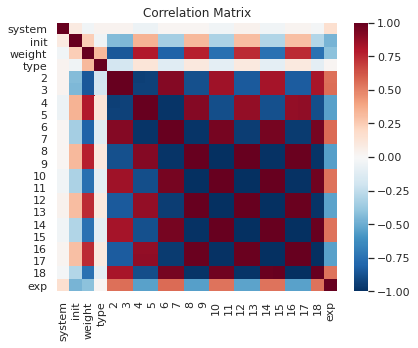

In [16]:
corr_mat_fig, corr_mat_plot = plt.subplots(figsize=(PLT_WIDTH, PLT_HEIGHT))

corr_mat_plot.set_title('Correlation Matrix')
corr_mat_plot = sns.heatmap(df.corr(),
                            ax     = corr_mat_plot,
                            vmin   = -1.0,
                            vmax   = 1.0,
                            cbar   = True,
                            cmap   = sns.color_palette('RdBu_r', 256),
                            center = 0.0
                           )

corr_mat_fig.tight_layout()
corr_mat_fig.savefig(path.join(IMG_PATH, 'corr_mat.pdf'), dpi=300, format='pdf')
corr_mat_fig.savefig(path.join(IMG_PATH, 'corr_mat.jpg'), dpi=300, format='jpg', quality=95, optimize=True, progressive=True)
plt.show()
plt.close(corr_mat_fig)

We then visualise the distribution of the values for each feature:

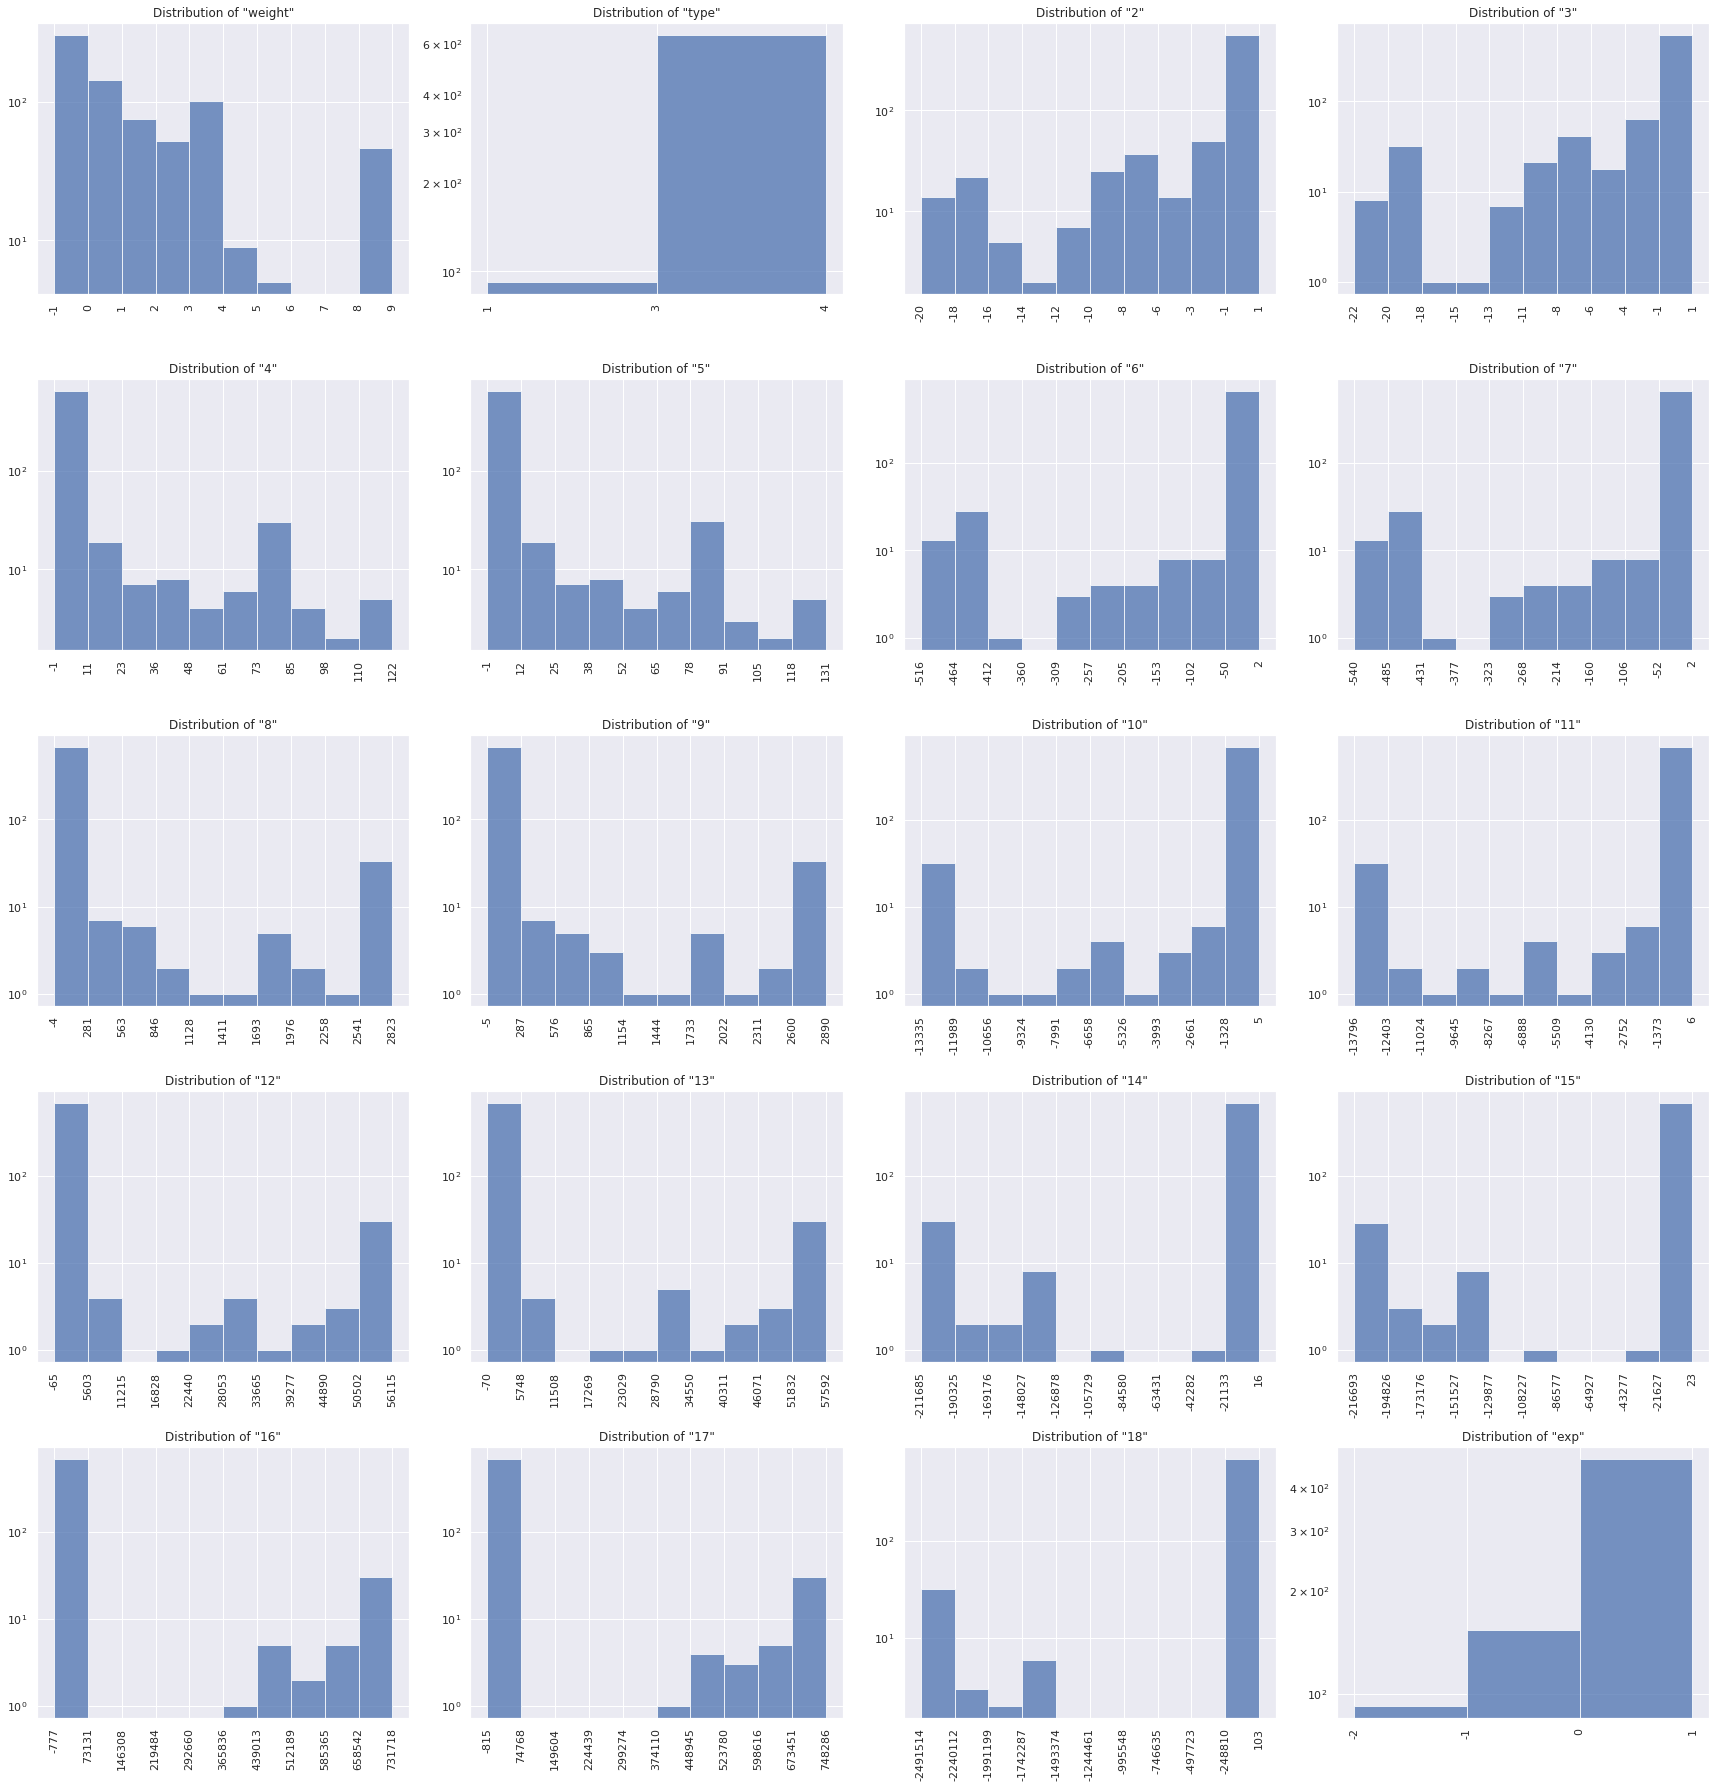

In [17]:
# define a version of the dataframe with only useful column for the plot
df_feature_plot = df.drop(columns=['init', 'system'])

# define a function to draw one single plot given a feature column and the no. of bins
def digitize_plot(feature, n_bins, ax):
    '''
    Digitize the given feature into a certain amount of bins.
    
    Required arguments:
        feature: the feature to digitize,
        n_bins:  the no. of bins,
        ax:      the ax of the subplot.
    '''
    # check how many unique values are in the column
    n_unique = pd.unique(feature).shape[0]
    if n_unique < n_bins:
        n_bins = n_unique #--------------------------------------- n_bins should not be greater than the no. of unique values
        
    # labels and bins
    labels, bins = pd.cut(feature, #------------------------------ the column to digitize
                          bins = n_bins, #------------------------ the no. of bins to create
                          labels = range(n_bins), #--------------- call the labels sequentially
                          retbins = True #------------------------ return also the bins
                         )
    
    # plot the histogram
    ax.hist(labels, bins = range(n_bins + 1), alpha = 0.75)
    ax.set_title('Distribution of "{}"'.format(feature.name))
    ax.set_xticks(range(n_bins + 1))
    ax.set_xticklabels(np.floor(bins).astype(int), rotation = 90)
    ax.set_yscale('log')
    
# now draw a grid of histograms
ncols = 4
nrows = 5

# choose the number of bins
n_bins = 10

# take the names of the feature sand distribute them in the grid
features = np.array(df_feature_plot.columns).reshape(nrows, ncols)

# create the plot
distr_feature_fig, distr_feature_plot = plt.subplots(ncols = ncols, nrows = nrows, figsize=(ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

for i in range(nrows):
    for j in range(ncols):
        digitize_plot(df_feature_plot[features[i,j]], n_bins, distr_feature_plot[i,j])

distr_feature_fig.tight_layout()
distr_feature_fig.savefig(path.join(IMG_PATH, 'distr_feature.pdf'), dpi=300, format='pdf')
distr_feature_fig.savefig(path.join(IMG_PATH, 'distr_feature.jpg'), dpi=300, format='jpg', quality=95, optimize=True, progressive=True)
plt.show()
plt.close(distr_feature_fig)

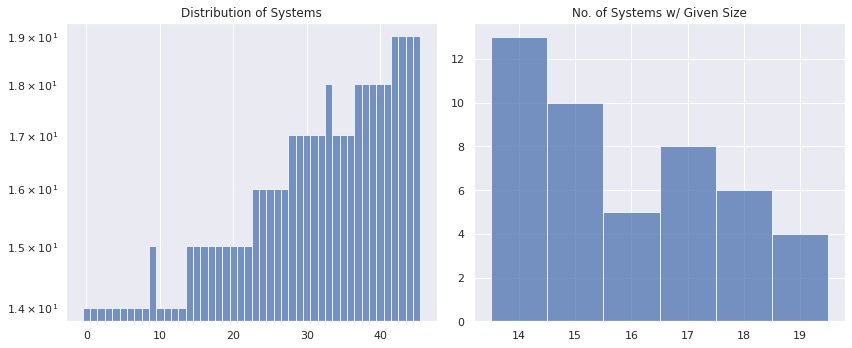

In [18]:
nrows = 1
ncols = 2
system_distr_fig, system_distr_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize=(ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

system_distr_plot[0].set(yscale = 'log', title = 'Distribution of Systems')
system_data = df['system']
system_distr_plot[0].hist(system_data,
                          bins = range(system_data.min(), system_data.max() + 2),
                          align = 'left',
                          alpha = 0.75
                         )

system_distr_plot[1].set(title = 'No. of Systems w/ Given Size')
size_data = df.groupby(by='system').count().max(axis=1)
system_distr_plot[1].hist(size_data,
                          bins = range(size_data.min(), size_data.max() + 2),
                          align = 'left',
                          alpha = 0.75
                         )

system_distr_fig.tight_layout()
system_distr_fig.savefig(path.join(IMG_PATH, 'system_distr.pdf'), dpi=300, format='pdf')
system_distr_fig.savefig(path.join(IMG_PATH, 'system_distr.jpg'), dpi=300, format='jpg', quality=95, optimize=True, progressive=True)
plt.show()
plt.close(system_distr_fig)

## Clustering Analysis

We now consider a quick clustering analysis using `K-Means` clustering to look for a pattern inside the data. The main idea would be to try and categorize the features into clusters with the same label.

In [19]:
n_clusters = pd.unique(df['exp']).shape[0]

In order to do so we first select the features:

In [20]:
# remove the 0-th system as it won't improve anything (it's "too perfect"), take everything but "system", "init" and the label
X = df.loc[df['system'] != 0].iloc[:,2:-1]

The we call the methods of the class `cluster.KMeans` in _Scikit_:

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = n_clusters, random_state = RAND)

log.info('Fitting KMeans clustering.')
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

We then include clustering labels and the `exp` column in a different dataframe for plotting:

In [22]:
data            = X
data['cluster'] = kmeans.labels_ - 1
data['exp']     = df.loc[df['system'] != 0]['exp']

Finally we plot the distribution of the clustering labels and the `exp` predictions using different colours for the labels and different style and size for the predictions.

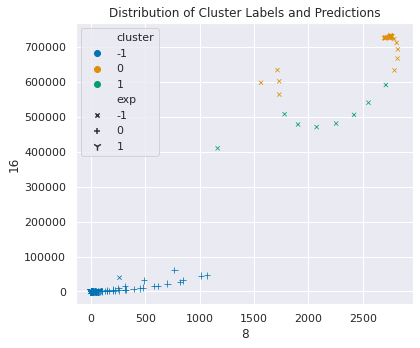

In [23]:
choice_x = np.random.choice(data.columns[2:-2], 1)[0] #----------------- random choice of the feature on x axis
choice_y = np.random.choice(data.columns[2:-2], 1)[0] #----------------- random choice of the feature on y axis
if choice_y == choice_x:
    choice_y = choice_y + 1 #------------------------------------------- make sure to always plot different things

cluster_labels_fig, cluster_labels_plot = plt.subplots(figsize=(PLT_WIDTH, PLT_HEIGHT))

cluster_labels_plot = sns.scatterplot(data    = data,
                                      x       = choice_x,
                                      y       = choice_y,
                                      hue     = 'cluster',
                                      style   = 'exp',
                                      size    = 'exp',
                                      legend  = 'full',
                                      palette = sns.color_palette('colorblind', 3),
                                      markers = ['x', '+', '1'],
                                      ax      = cluster_labels_plot
                                     )
cluster_labels_plot.set(title = 'Distribution of Cluster Labels and Predictions')
cluster_labels_plot.legend(loc='best')

cluster_labels_fig.tight_layout()
cluster_labels_fig.savefig(path.join(IMG_PATH, 'cluster_labels.pdf'), dpi=300, format='pdf')
cluster_labels_fig.savefig(path.join(IMG_PATH, 'cluster_labels.jpg'), dpi=300, format='jpg', quality=95, optimize=True, progressive=True)
plt.show()
plt.close(cluster_labels_fig)

A match between clustering labels and predictions should be seen as a match between colours and marker style and size: this not the case however.

## Saving the Dataset

We can now save the dataset for further use.

In [24]:
df = df.loc[df['system'] != 0] #------------------------- drop the first system
df = df.reset_index(drop = True) #----------------------- reset the index

fp = path.join(ROOT_DIR, 'data_sft_analysis.csv') #------ choose the filepath
df.to_csv(fp) #------------------------------------------ save the dataset

log.debug('Dataset saved to CSV file.')